# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [1]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta

from scipy.stats import norm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

import statsmodels.formula.api as smf
import statsmodels.api as sm

import pickle

In [2]:
kc_df = pd.read_csv('kc_house_data_train.csv')
# kc_house_test = pd.read_csv('kc_house_data_test_features.csv')

## Step 2: Exploratory Data Analysis
Become familiar with the data. Look to see if there are any extreme values.
Additionally create data visualizations to determine if there are any relationships between your features and your target variables.


In [3]:
kc_df

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,...,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,...,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,...,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,...,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028


In [4]:
#Keeping the ID column
kc_id = kc_df['id']
#dropping the ID
kc_df.drop(['id', 'Unnamed: 0', 'date'], axis = 1, inplace = True)

In [130]:
kc_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028


In [320]:
# kc_df = kc_df.reset_index()


In [321]:
price_corr = kc_df[kc_df.columns[:]].corr()['price'][:]
price_corr.sort_values()

zipcode         -0.048958
long             0.019327
condition        0.036099
yr_built         0.056450
sqft_lot15       0.081423
sqft_lot         0.086803
yr_renovated     0.117770
floors           0.256985
waterfront       0.275779
lat              0.302394
bedrooms         0.305106
sqft_basement    0.323312
view             0.395485
bathrooms        0.524335
sqft_living15    0.585567
sqft_above       0.607760
grade            0.666215
sqft_living      0.703540
price            1.000000
Name: price, dtype: float64

/Users/christadawson/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


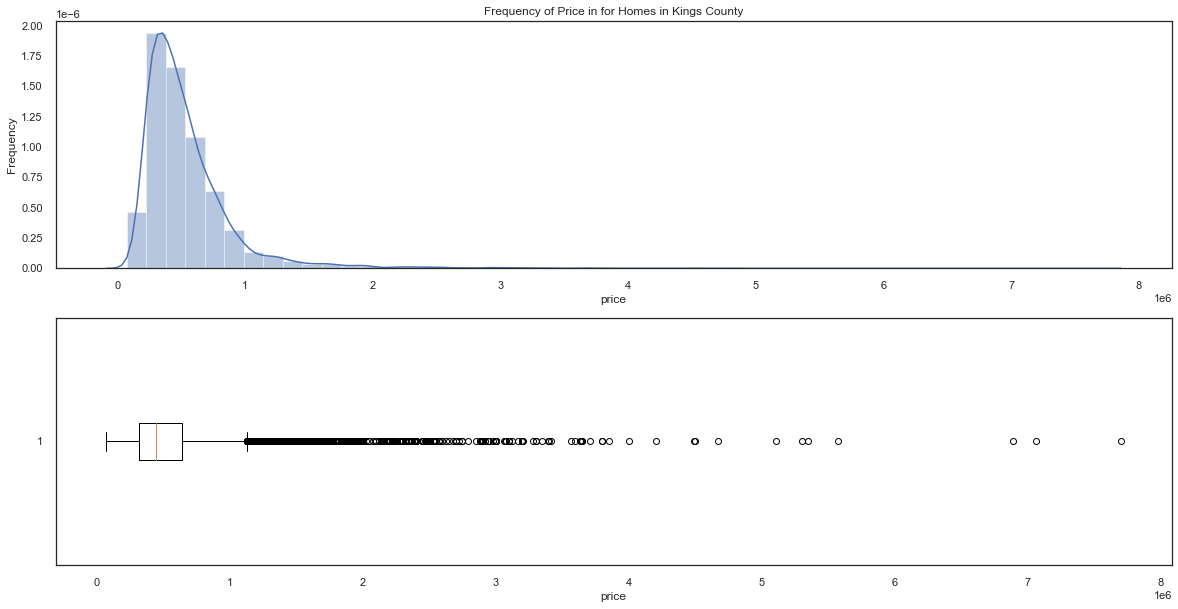

In [322]:
fig = plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.ylabel('Frequency')
plt.title('Frequency of Price in for Homes in Kings County')
sns.distplot(kc_df['price'])
plt.subplot(2,1,2)
plt.boxplot(kc_df['price'], vert= False)
plt.xlabel('price')
plt.show()

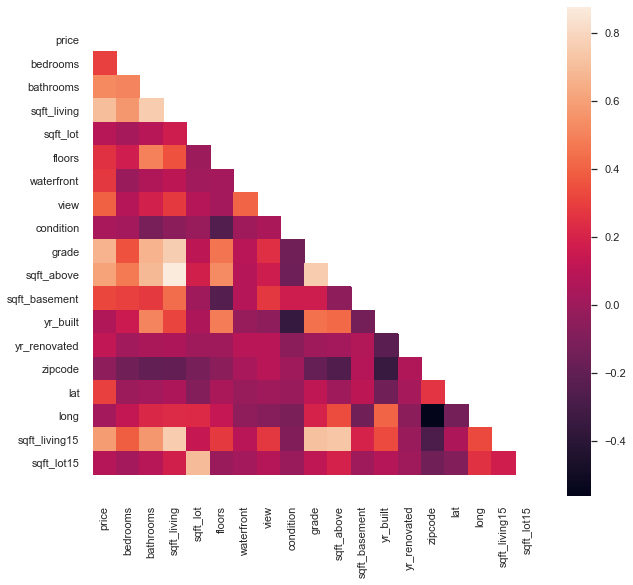

In [323]:
plt.style.use('seaborn')
sns.set(style="white") 
f, ax = plt.subplots(figsize=(10, 9))
mask = np.zeros_like(kc_df.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(kc_df.corr(), mask=mask, square=True)
b, t = plt.ylim() 
b += .75
t -= .75 
plt.ylim(b, t) 
plt.show()

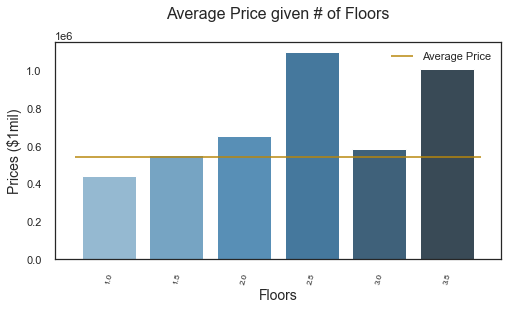

In [324]:
floor_price = kc_df.groupby('floors')['price'].mean()
# .sort_values(ascending = False)
kc_mean_price = kc_df.price.mean()
#top5 neighborhood label for plot

#plotting the data
plt.subplots(figsize=(8,4))
sns.barplot(x=floor_price.index, y=floor_price, order=floor_price.index, palette="Blues_d")
plt.xticks(np.arange(6), rotation=75, size=8) #relabel x with list above
plt.hlines(kc_mean_price,  -.5 , 5.5, colors="darkgoldenrod", label="Average Price") #plot average price horizontal line

#create labels on graph
plt.xlabel("Floors", size=14)
plt.ylabel("Prices ($1mil)", size=14)
plt.title("Average Price given # of Floors", size=16, y=1.08)
plt.legend() #show legend
plt.show();


In [325]:
alpha = 0.05 
#ANOVA Test Setup
formula = 'price~condition'
lm_condition = smf.ols(formula, kc_df).fit()
anova_condition = sm.stats.anova_lm(lm_condition, typ=2)

if anova_condition["PR(>F)"][0] < alpha:
    print("The property condition have a statistically significant impact on average property value")
    print("Conditions F-statisic Probability: ", anova_condition["PR(>F)"][0])

The property condition have a statistically significant impact on average property value
Conditions F-statisic Probability:  2.0554674592701098e-06


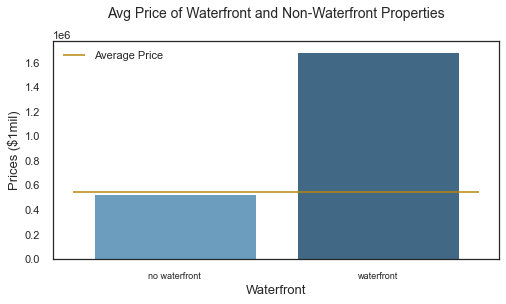

In [326]:
waterfront_price = kc_df.groupby('waterfront')['price'].mean()
# .sort_values(ascending = False)
kc_mean_price = kc_df.price.mean()
#top5 neighborhood label for plot
water_labels=['no waterfront','waterfront']
#plotting the data
plt.subplots(figsize=(8,4))
sns.barplot(x=waterfront_price.index, y=waterfront_price, order=waterfront_price.index, palette="Blues_d")
plt.xticks(np.arange(2), water_labels, rotation=0, size=9) #relabel x with list above
plt.hlines(kc_mean_price,  -.5 , 1.5, colors="darkgoldenrod", label="Average Price") #plot average price horizontal line

#create labels on graph
plt.xlabel("Waterfront", size=13)
plt.ylabel("Prices ($1mil)", size=13)
plt.title("Avg Price of Waterfront and Non-Waterfront Properties", size=14, y=1.08)
plt.legend() #show legend
plt.show();


In [327]:
is_waterfront = kc_df[(kc_df['waterfront'] == 1)]
waterfront_price = is_waterfront.price
no_waterfront = kc_df[(kc_df['waterfront'] == 0)]
notwaterfront_price = no_waterfront.price

alpha = 0.05
waterfront_p_val = stats.ttest_ind(waterfront_price, notwaterfront_price, equal_var=False)[1]
print("Waterfront vs No Waterfront T-test P Value: ", waterfront_p_val)
if waterfront_p_val < alpha:
    print("The P value is less than alpha, reject null-hypothesis")

Waterfront vs No Waterfront T-test P Value:  6.940441256090536e-23
The P value is less than alpha, reject null-hypothesis


In [328]:
kc_df['basement'] = np.where(kc_df['sqft_basement'] != 0, 1, 0)
#Sets sqft_basement to categorical data
kc_df["reno"] = kc_df.yr_renovated.apply(lambda x: 1 if x != 0 else 0)
#sets yr_renovated to categorical set of if it has been or not
kc_df['master_br'] = np.where(kc_df['bedrooms'] > 2, 1, 0)
#Sets master_br variable being likely in a house

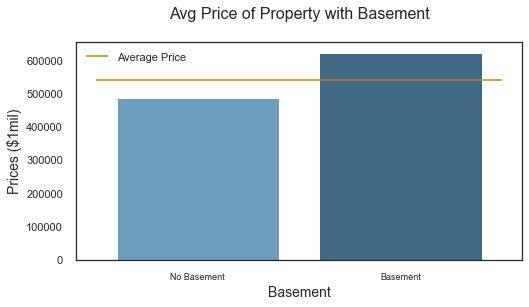

In [329]:
basement_price = kc_df.groupby('basement')['price'].mean()
# .sort_values(ascending = False)
kc_mean_price = kc_df.price.mean()
#top5 neighborhood label for plot
labels = ['No Basement', 'Basement']
#plotting the data
plt.subplots(figsize=(8,4))
sns.barplot(x=basement_price.index, y=basement_price, order=basement_price.index, palette="Blues_d")
plt.xticks(np.arange(2), labels, rotation=0, size=9) #relabel x with list above
plt.hlines(kc_mean_price,  -.5 , 1.5, colors="darkgoldenrod", label="Average Price") #plot average price horizontal line

#create labels on graph
plt.xlabel("Basement", size=14)
plt.ylabel("Prices ($1mil)", size=14)
plt.title("Avg Price of Property with Basement", size=16, y=1.08)
plt.legend() #show legend
plt.show();

In [330]:
is_basement = kc_df[(kc_df['sqft_basement']> 0)]
basement_price = is_basement.price
no_basement = kc_df[(kc_df['sqft_basement'] == 0)]
no_basement_price = no_waterfront.price

alpha = 0.05
basement_p_val = stats.ttest_ind(basement_price, no_basement_price, equal_var=False)[1]
print("Basement vs No Basement T-test P Value: ", basement_p_val)
if basement_p_val < alpha:
    print("The P value is less than alpha, reject null-hypothesis")

Basement vs No Basement T-test P Value:  4.897332653268288e-50
The P value is less than alpha, reject null-hypothesis


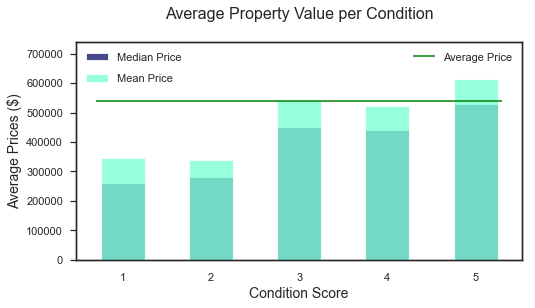

In [331]:
mean = kc_df.groupby("condition")["price"].mean()
median = kc_df.groupby("condition")["price"].median()
score = np.arange(1,6)

fig, ax = plt.subplots(figsize=(8,4))
ax2 = ax.twinx() #set ax2 on same x axis as ax
ax3 = ax.twinx() #same as above, for hline
width = 0.5

ax.bar(x=score, height=median, width=width,
       label="Median Price", color="midnightblue", alpha=0.8)
ax2.bar(x=score, height=mean, width=width,
        label="Mean Price", color="aquamarine", alpha=0.8)
ax3.hlines(kc_mean_price, .7 ,5.3, colors="green", label="Average Price")

ax.set_ylim(0,1.2*mean.max())
ax2.set_ylim(0,1.2*mean.max())
ax3.set_ylim(0,1.2*mean.max())
ax2.yaxis.set_visible(False) #hide the 2nd axis
ax3.yaxis.set_visible(False)

ax.legend(bbox_to_anchor=(0,0,1,1), loc="upper left")
ax2.legend(bbox_to_anchor=(0,-.1,1,1), loc="upper left")
ax3.legend(bbox_to_anchor=(0,0,1,1), loc="upper right")

ax.set_ylabel("Average Prices ($)", size=14)
ax.set_xlabel("Condition Score", size=14)
plt.title("Average Property Value per Condition", size=16, y=1.08)

plt.legend()
plt.show();

In [332]:
alpha = 0.05 
#ANOVA Test Setup
formula = 'price~C(condition)'
lm_condition = smf.ols(formula, kc_df).fit()
anova_condition = sm.stats.anova_lm(lm_condition, typ=2)

if anova_condition["PR(>F)"][0] < alpha:
    print("The property condition have a statistically significant impact on average property value")
    print("Conditions F-statisic Probability: ", anova_condition["PR(>F)"][0])

The property condition have a statistically significant impact on average property value
Conditions F-statisic Probability:  6.813536869395142e-24


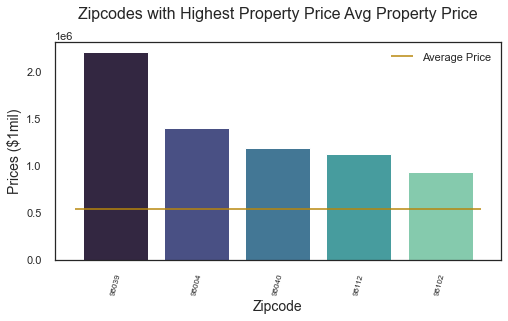

In [333]:
#property values by zipcode calculation
kc_top_price = kc_df.groupby("zipcode")["price"].mean().sort_values(ascending=False)[:5]
# .sort_values(ascending = False)
kc_mean_price = kc_df.price.mean()

#plotting the data
plt.subplots(figsize=(8,4))
sns.barplot(x=kc_top_price.index, y=kc_top_price, order=kc_top_price.index, palette="mako")
plt.xticks(np.arange(5), rotation=75, size=8) #relabel x with list above
plt.hlines(kc_mean_price,  -.5 , 4.5, colors="darkgoldenrod", label="Average Price") #plot average price horizontal line

#create labels on graph
plt.xlabel("Zipcode", size=14)
plt.ylabel("Prices ($1mil)", size=14)
plt.title("Zipcodes with Highest Property Price Avg Property Price", size=16, y=1.08)
plt.legend() #show legend
plt.show();

In [334]:
alpha = 0.05 
#ANOVA Test Setup
kc_top5 = kc_df[kc_df.zipcode.isin(kc_top_price.index)]
formula = 'price~C(zipcode)'
lm_top5 = smf.ols(formula, kc_top5).fit()
anova_top5_table = sm.stats.anova_lm(lm_top5, typ=2)

if anova_top5_table["PR(>F)"][0] < alpha:
    print("Top 5 ranked zipcode have a statistically significant impact on average property value")
    print("Zipcdoe ANOVA F-statisic Probability: ", anova_top5_table["PR(>F)"][0])

Top 5 ranked zipcode have a statistically significant impact on average property value
Zipcdoe ANOVA F-statisic Probability:  1.251556022310978e-19


## Step 3: Clean up any issues (extreme values, etc.) with the data.
Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it.

In [5]:
def n_bath(row):
    if row['bathrooms'] == 0:
        row['bathrooms'] = 1
    if row['bathrooms'] > 10:
        row['bathrooms'] = 10
    return row
kc_df = kc_df.apply(n_bath, axis = 1)

In [6]:
def n_bed(row):
    if row['bedrooms'] ==0:
        row['bedrooms'] = row['floors']
    if row['bedrooms'] > 10:
        row['bedrooms'] = 10
    return row
kc_df = kc_df.apply(n_bed, axis = 1)

In [7]:
kc_df['sqft_basement'] = np.where(kc_df['sqft_basement'] != 0, 1, 0)
#Sets sqft_basement to categorical data
kc_df['master_br'] = np.where(kc_df['bedrooms'] > 2, 1, 0)
#Sets master_br variable being likely in a house

## Step 4: Feature Engineering

In [369]:
def high_corr(df, alpha = 0.7):
    corr = df[[cor for cor in df.columns if cor != 'price']].corr()
    corr_tuples = [(f, list(s[abs(s) > alpha].index)) for f,s in corr.iteritems()]
    for t1, t2 in corr_tuples:
        if t1 in t2:
            t2.remove(t1)
    corr_f = [t for t in corr_tuples if len(t[1]) != 0]
    highly_corr = []
    for t in corr_f:
        for f in t[1]:
            highly_corr.append(f)
    return list(set(highly_corr))

In [370]:
high_corr(kc_df)

['sqft_above',
 'sqft_living',
 'sqft_lot',
 'bathrooms',
 'sqft_living15',
 'grade',
 'sqft_lot15']

In [9]:
# def city_distance(row):
#     dist = geopy.distance.geodesic((47.6205,122.3493), (row['lat'], abs(row['long'])))
#     return dist.miles

In [10]:
# kc_df['dist_city'] = kc_df.apply(city_distance, axis=1)

In [8]:
kc_df.drop(['lat', 'long'], axis = 1, inplace = True)

In [9]:
kc_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,master_br
0,365000.0,4.0,2.25,2070.0,8893.0,2.0,0.0,0.0,4.0,8.0,2070.0,0,1986.0,0.0,98058.0,2390.0,7700.0,1
1,865000.0,5.0,3.00,2900.0,6730.0,1.0,0.0,0.0,5.0,8.0,1830.0,1,1977.0,0.0,98115.0,2370.0,6283.0,1
2,1038000.0,4.0,2.50,3770.0,10893.0,2.0,0.0,2.0,3.0,11.0,3770.0,0,1997.0,0.0,98006.0,3710.0,9685.0,1
3,1490000.0,3.0,3.50,4560.0,14608.0,2.0,0.0,2.0,3.0,12.0,4560.0,0,1990.0,0.0,98034.0,4050.0,14226.0,1
4,711000.0,3.0,2.50,2550.0,5376.0,2.0,0.0,0.0,3.0,9.0,2550.0,0,2004.0,0.0,98052.0,2250.0,4050.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5.0,2.50,3240.0,9960.0,1.0,0.0,1.0,3.0,8.0,2020.0,1,1958.0,0.0,98008.0,2730.0,10400.0,1
17286,440000.0,2.0,1.75,1300.0,4000.0,2.0,0.0,0.0,3.0,7.0,1300.0,0,1948.0,0.0,98105.0,1350.0,4013.0,0
17287,310000.0,3.0,1.00,1050.0,9876.0,1.0,0.0,0.0,3.0,7.0,1050.0,0,1953.0,0.0,98028.0,1760.0,9403.0,1
17288,427500.0,3.0,1.50,1900.0,43186.0,1.5,0.0,0.0,4.0,7.0,1300.0,1,1971.0,0.0,98038.0,2080.0,108028.0,1


### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [11]:
cat_var = ['zipcode', 'grade', 'waterfront']
cont_var = ['bedrooms', 'bathrooms', 'dist_city', 'sqft_living', 'sqft_lot', 'yr_updated']


In [12]:
# your code here
# fuction to generate a dummy variable for a feature
# needs tweeks
def to_dummies(df, features):
    """
    Generating dummy variables for feature
    parama: df
            features - list of features
    """
    d_df = []
    for f in features:
        d_df.append(pd.get_dummies(df[f], prefix='{}'.format(str(f)[:3]), drop_first=True))
    df = df.drop(features, axis = 1)
    df = pd.concat([df] + d_df ,axis=1)
    return df

In [13]:
kc_df = to_dummies(kc_df, cat_var)


In [14]:
kc_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,...,gra_5.0,gra_6.0,gra_7.0,gra_8.0,gra_9.0,gra_10.0,gra_11.0,gra_12.0,gra_13.0,wat_1.0
0,365000.0,4.0,2.25,2070.0,8893.0,2.0,0.0,4.0,2070.0,0,...,0,0,0,1,0,0,0,0,0,0
1,865000.0,5.0,3.00,2900.0,6730.0,1.0,0.0,5.0,1830.0,1,...,0,0,0,1,0,0,0,0,0,0
2,1038000.0,4.0,2.50,3770.0,10893.0,2.0,2.0,3.0,3770.0,0,...,0,0,0,0,0,0,1,0,0,0
3,1490000.0,3.0,3.50,4560.0,14608.0,2.0,2.0,3.0,4560.0,0,...,0,0,0,0,0,0,0,1,0,0
4,711000.0,3.0,2.50,2550.0,5376.0,2.0,0.0,3.0,2550.0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5.0,2.50,3240.0,9960.0,1.0,1.0,3.0,2020.0,1,...,0,0,0,1,0,0,0,0,0,0
17286,440000.0,2.0,1.75,1300.0,4000.0,2.0,0.0,3.0,1300.0,0,...,0,0,1,0,0,0,0,0,0,0
17287,310000.0,3.0,1.00,1050.0,9876.0,1.0,0.0,3.0,1050.0,0,...,0,0,1,0,0,0,0,0,0,0
17288,427500.0,3.0,1.50,1900.0,43186.0,1.5,0.0,4.0,1300.0,1,...,0,0,1,0,0,0,0,0,0,0


### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

In [15]:
def yr_update(row):
    if row['yr_renovated'] == 0:
        row['yr_updated'] = 2021 - row['yr_built']
    elif row['yr_renovated'] != 0:
        row['yr_updated'] = 2021 - row['yr_renovated']
    return row['yr_updated']

In [16]:
kc_df['yr_updated'] = kc_df.apply(yr_update, axis=1)

In [18]:
# kc_df.drop(columns = ['yr_built', 'yr_renovated'], axis = 1, inplace = True)

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [21]:
kc_df['sqft_living_sqft_lot'] = kc_df['sqft_living'] * kc_df['sqft_lot']

In [18]:
summary_features = list(kc_df.columns.drop('price'))


In [19]:
summary_features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'sqft_living15',
 'sqft_lot15',
 'master_br',
 'zip_98002.0',
 'zip_98003.0',
 'zip_98004.0',
 'zip_98005.0',
 'zip_98006.0',
 'zip_98007.0',
 'zip_98008.0',
 'zip_98010.0',
 'zip_98011.0',
 'zip_98014.0',
 'zip_98019.0',
 'zip_98022.0',
 'zip_98023.0',
 'zip_98024.0',
 'zip_98027.0',
 'zip_98028.0',
 'zip_98029.0',
 'zip_98030.0',
 'zip_98031.0',
 'zip_98032.0',
 'zip_98033.0',
 'zip_98034.0',
 'zip_98038.0',
 'zip_98039.0',
 'zip_98040.0',
 'zip_98042.0',
 'zip_98045.0',
 'zip_98052.0',
 'zip_98053.0',
 'zip_98055.0',
 'zip_98056.0',
 'zip_98058.0',
 'zip_98059.0',
 'zip_98065.0',
 'zip_98070.0',
 'zip_98072.0',
 'zip_98074.0',
 'zip_98075.0',
 'zip_98077.0',
 'zip_98092.0',
 'zip_98102.0',
 'zip_98103.0',
 'zip_98105.0',
 'zip_98106.0',
 'zip_98107.0',
 'zip_98108.0',
 'zip_98109.0',
 'zip_98112.0',
 'zip_98115.0',
 'zip_98116.0',


In [197]:
kc_df_poly2

,bedrooms_x,bathrooms_x,dist_city_x,sqft_living_x,sqft_lot_x,yr_updated_x,bedrooms^2,bedrooms bathrooms,bedrooms dist_city,bedrooms sqft_living,...,gra_7.0,gra_8.0,gra_9.0,gra_10.0,gra_11.0,gra_12.0,gra_13.0,wat_1.0,sqf_1,yr_updated_y
0,5.0,2.75,25.078309,2481.0,4045.0,7.0,25.0,13.75,125.391543,12405.0,...,0,1,0,0,0,0,0,0,0,7.0
1,3.0,2.50,22.118798,1830.0,4997.0,17.0,9.0,7.50,66.356393,5490.0,...,1,0,0,0,0,0,0,0,0,17.0
2,5.0,2.25,19.966981,2320.0,6375.0,54.0,25.0,11.25,99.834907,11600.0,...,1,0,0,0,0,0,0,0,1,54.0
3,3.0,1.00,24.115052,1150.0,19200.0,113.0,9.0,3.00,72.345156,3450.0,...,0,0,0,0,0,0,0,0,0,113.0
4,3.0,1.00,24.168831,940.0,10890.0,112.0,9.0,3.00,72.506493,2820.0,...,0,0,0,0,0,0,0,0,0,112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,2.0,1.00,3.021653,810.0,6480.0,79.0,4.0,2.00,6.043306,1620.0,...,0,0,0,0,0,0,0,0,0,79.0
17286,4.0,2.50,3.328100,3690.0,11191.0,70.0,16.0,10.00,13.312400,14760.0,...,0,0,0,1,0,0,0,0,1,70.0
17287,3.0,2.50,3.269251,3560.0,8297.0,73.0,9.0,7.50,9.807754,10680.0,...,0,1,0,0,0,0,0,0,1,73.0
17288,2.0,2.50,2.838135,2720.0,4913.0,85.0,4.0,5.00,5.676270,5440.0,...,0,1,0,0,0,0,0,0,1,85.0


## Step 5: Train-Test Split

If you plan on doing any scaling of your data, make sure it is done at the appropriate time. 

### 5.1) Perform a train-test split of the data.

In [20]:
target=kc_df['price']

In [21]:
def model_test(df, features, target):
    target = df[target]
    df_feature = df[features]
    x_train, x_test, y_train, y_test = train_test_split(df_feature, 
    target, random_state = 34, test_size = 0.2)
    lm = linear_model.LinearRegression()
    lm = lm.fit(x_train, y_train)
    y_train_pred = lm.predict(x_train)
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    y_test_pred = lm.predict(x_test)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    print('Training: ', int(train_rmse), 'vs. Testing: ', int(test_rmse))

In [22]:
model_test(kc_df, summary_features, ['price'])

Training:  150777 vs. Testing:  154917


In [23]:
#your code here 
#improt train_test_split from sklearn package
from sklearn.model_selection import train_test_split
#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(kc_df[summary_features], target, random_state=34,test_size=0.2)
#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (13832, 97) Target:  (13832,)
Training set - Features:  (3458, 97) Target:  (3458,)


In [24]:
from sklearn import linear_model
#instantiate a linear regression object
lm = linear_model.LinearRegression()
#fit the linear regression to the data
lm = lm.fit(X_train, y_train)
#print the y_intercept of our model
print(lm.intercept_)
#print the coefficents of each of our features
print(lm.coef_)

1887834.2268693063
[-1.89902055e+04  2.33803895e+04  1.44761442e+02  8.36324706e-01
 -3.04477942e+04  4.89525789e+04  3.17159725e+04  3.53736611e+01
 -1.97583776e+04 -9.90887553e+02  1.16081786e+00  1.06672050e+01
 -9.53519984e-02  1.77913881e+04  1.82251286e+03 -1.25927651e+04
  7.93904543e+05  2.83324399e+05  2.36810352e+05  2.55996926e+05
  2.54985504e+05  5.68657842e+04  1.36026936e+05  8.75368889e+04
  8.78842198e+04 -3.01802386e+04 -3.43701524e+04  1.54288059e+05
  1.63062036e+05  1.33830064e+05  2.09873826e+05  3.55924142e+03
  1.08676793e+04  5.42545786e+03  3.44703059e+05  2.04813584e+05
  2.78378589e+04  1.19380376e+06  5.06991850e+05  1.52707899e+00
  9.28626612e+04  2.36526091e+05  2.06036922e+05  4.35012895e+04
  8.74402674e+04  3.34681512e+04  7.46676789e+04  8.28381959e+04
 -2.76165810e+04  1.57104172e+05  1.75960022e+05  1.58102227e+05
  1.00871740e+05 -3.20480542e+04  5.26641655e+05  3.60536382e+05
  4.75813658e+05  1.29264886e+05  3.62522720e+05  1.28873514e+05
  4.90

In [25]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [26]:
from sklearn import metrics
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Root Mean Squared Error:' , train_rmse)

Root Mean Squared Error: 150777.46867589888


In [27]:
price_std = target.std()
print('Z-Score of Root Mean Squared Error:' , train_rmse/price_std)

y_pred = lm.predict(X_test)

print ("Score:", lm.score(X_test, y_test))

test_mae = metrics.mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:' + str(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error:' + str(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print('Mean Absolute Error  Z:', test_mae/price_std)
print('Root Mean Squared Error Z:' , test_rmse/price_std)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Z-Score of Root Mean Squared Error: 0.4038837489083558
Score: 0.8320757325174764
Mean Absolute Error:90727.44723264634
Mean Squared Error:23999450787.463318
Root Mean Squared Error:154917.56126231563
Mean Absolute Error  Z: 0.24302929236709964
Root Mean Squared Error Z: 0.4149737090284846
Training:  150777 vs. Testing:  154917


In [28]:
print ("R^2 Score:", lm.score(X_train, y_train))

R^2 Score: 0.8358188880182084


### 5.2) Fit your scaler to training the data.

In [29]:
from sklearn.preprocessing import StandardScaler
# setting scaler equal to our function
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
scaled_data = scaler.transform(X_train)

In [30]:
#create dataframe
X_train_scaled = pd.DataFrame(data=scaled_data, columns=X_train.columns, index=X_train.index)

In [31]:
scaled_test_data = scaler.transform(X_test)

#create dataframe
X_test_scaled = pd.DataFrame(data=scaled_test_data, columns=X_test.columns, index=X_test.index)

In [32]:
#transform the test data


### 5.4) Fit the model to the training data.

In [33]:
#your code here 
from sklearn.linear_model import LinearRegression

lm = linear_model.LinearRegression()
#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

print(lm.intercept_)
print(lm.coef_)

1887834.2268693063
[-1.89902055e+04  2.33803895e+04  1.44761442e+02  8.36324706e-01
 -3.04477942e+04  4.89525789e+04  3.17159725e+04  3.53736611e+01
 -1.97583776e+04 -9.90887553e+02  1.16081786e+00  1.06672050e+01
 -9.53519984e-02  1.77913881e+04  1.82251286e+03 -1.25927651e+04
  7.93904543e+05  2.83324399e+05  2.36810352e+05  2.55996926e+05
  2.54985504e+05  5.68657842e+04  1.36026936e+05  8.75368889e+04
  8.78842198e+04 -3.01802386e+04 -3.43701524e+04  1.54288059e+05
  1.63062036e+05  1.33830064e+05  2.09873826e+05  3.55924142e+03
  1.08676793e+04  5.42545786e+03  3.44703059e+05  2.04813584e+05
  2.78378589e+04  1.19380376e+06  5.06991850e+05  1.52707899e+00
  9.28626612e+04  2.36526091e+05  2.06036922e+05  4.35012895e+04
  8.74402674e+04  3.34681512e+04  7.46676789e+04  8.28381959e+04
 -2.76165810e+04  1.57104172e+05  1.75960022e+05  1.58102227e+05
  1.00871740e+05 -3.20480542e+04  5.26641655e+05  3.60536382e+05
  4.75813658e+05  1.29264886e+05  3.62522720e+05  1.28873514e+05
  4.90

### 5.5) Use the model to predict on the training set and the test set.

In [35]:
#your code here 
y_train_pred = lm.predict(X_train)

y_test_pred = lm.predict(X_test)

### 5.6) Evaluate the training and test predictions using RMSE.

In [36]:
#your code here 
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Training Root Mean Squared Error:' , train_rmse)
print('Training Root Mean Squared Error:' , test_rmse)

Training Root Mean Squared Error: 150777.46867589888
Training Root Mean Squared Error: 154917.56126231563


### 5.7) Determine if your model is overfit.

In [37]:
print('Perfomance : {} %'.format(round(abs((test_rmse-train_rmse)/train_rmse)*100)))

Perfomance : 3 %


## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [38]:
from sklearn.feature_selection import RFECV

ols = LinearRegression()
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=2, cv=7,  scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Fit recursive feature eliminator 

selector.fit(X_train, y_train)


Fitting estimator with 97 features.


RFECV(cv=7, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_absolute_error', step=2, verbose=1)

In [39]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [40]:
from sklearn.feature_selection import RFECV

In [41]:
def RFECV_selection(df, y):
    from sklearn.feature_selection import RFECV
    X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=9, test_size=0.2)
    scaler = StandardScaler()
    # fit the scaler to the training data
    scaler.fit(X_train)
    #transform the training data
    scaled_data = scaler.transform(X_train)
    X_train_scaled = pd.DataFrame(data=scaled_data, columns=df.columns, index=X_train.index)
    #transform the test data
    scaled_test_data = scaler.transform(X_test)
    #create dataframe
    X_test_scaled = pd.DataFrame(data=scaled_test_data, columns=df.columns, index=X_test.index)
    ols = LinearRegression()
    # Create recursive feature eliminator that scores features by mean squared errors
    selector = RFECV(estimator=ols, step=2, cv=7,  scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    # Fit recursive feature eliminator 
    selector.fit(X_train_scaled, y_train)
    selected_rfe = X_train_scaled.columns[selector.support_]
    removed_rfe = X_train_scaled.columns[~selector.support_]
    #instantiate a linear regression object
    lm_rfe = LinearRegression()
    #fit the linear regression to the data
    lm_rfe = lm_rfe.fit(X_train_scaled[selected_rfe], y_train)
    y_rfe = lm_rfe.predict(X_train_scaled[selected_rfe])
    trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
    print('Training Root Mean Squared Error:' , trainRFE_rmse)
    y_pred_rfe = lm_rfe.predict(X_test_scaled[selected_rfe])
    testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
    print('Testing Root Mean Squared Error:' , testRFE_rmse)
    print('Most Importand features acoring to RFECV :')
    return selected_rfe

In [42]:
RFECV_selection(kc_df[summary_features], target)

Fitting estimator with 97 features.
Fitting estimator with 95 features.
Fitting estimator with 93 features.
Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
Training Root Mean Squared Error: 152612.15927615564
Testing Root Mean Squared Error: 147303.74038758417
Most Importand features acoring to RFECV :


Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15',
       'sqft_lot15', 'master_br', 'zip_98004.0', 'zip_98005.0', 'zip_98006.0',
       'zip_98007.0', 'zip_98008.0', 'zip_98010.0', 'zip_98011.0',
       'zip_98014.0', 'zip_98019.0', 'zip_98022.0', 'zip_98023.0',
       'zip_98024.0', 'zip_98027.0', 'zip_98028.0', 'zip_98029.0',
       'zip_98033.0', 'zip_98034.0', 'zip_98038.0', 'zip_98039.0',
       'zip_98040.0', 'zip_98045.0', 'zip_98052.0', 'zip_98053.0',
       'zip_98055.0', 'zip_98056.0', 'zip_98058.0', 'zip_98059.0',
       'zip_98065.0', 'zip_98072.0', 'zip_98074.0', 'zip_98075.0',
       'zip_98077.0', 'zip_98092.0', 'zip_98102.0', 'zip_98103.0',
       'zip_98105.0', 'zip_98106.0', 'zip_98107.0', 'zip_98108.0',
       'zip_98109.0', 'zip_98112.0', 'zip_98115.0', 'zip_98116.0',
       'zip_98117.0', 'zip_98118.0', 'zip_98119.0', 'zip_98122.0',
       'zip_98125.0', 'zip_

In [341]:
kc_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,basement,reno,master_br,percent_bedbath
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,...,0,98058,47.4388,-122.162,2390,7700,0,0,1,NaN
1,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,...,1070,98115,47.6784,-122.285,2370,6283,1,0,1,NaN
2,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,...,0,98006,47.5646,-122.129,3710,9685,0,0,1,NaN
3,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,...,0,98034,47.6995,-122.228,4050,14226,0,0,1,NaN
4,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,...,0,98052,47.6647,-122.083,2250,4050,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,...,1220,98008,47.5858,-122.112,2730,10400,1,0,1,NaN
17286,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,...,0,98105,47.6687,-122.288,1350,4013,0,0,0,NaN
17287,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,...,0,98028,47.7635,-122.262,1760,9403,0,0,1,NaN
17288,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,...,600,98038,47.4199,-121.990,2080,108028,1,0,1,NaN


In [43]:
best_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15',
       'sqft_lot15', 'master_br', 'zip_98004.0', 'zip_98005.0', 'zip_98006.0',
       'zip_98007.0', 'zip_98008.0', 'zip_98010.0', 'zip_98011.0',
       'zip_98014.0', 'zip_98019.0', 'zip_98022.0', 'zip_98023.0',
       'zip_98024.0', 'zip_98027.0', 'zip_98028.0', 'zip_98029.0',
       'zip_98033.0', 'zip_98034.0', 'zip_98038.0', 'zip_98039.0',
       'zip_98040.0', 'zip_98045.0', 'zip_98052.0', 'zip_98053.0',
       'zip_98055.0', 'zip_98056.0', 'zip_98058.0', 'zip_98059.0',
       'zip_98065.0', 'zip_98072.0', 'zip_98074.0', 'zip_98075.0',
       'zip_98077.0', 'zip_98092.0', 'zip_98102.0', 'zip_98103.0',
       'zip_98105.0', 'zip_98106.0', 'zip_98107.0', 'zip_98108.0',
       'zip_98109.0', 'zip_98112.0', 'zip_98115.0', 'zip_98116.0',
       'zip_98117.0', 'zip_98118.0', 'zip_98119.0', 'zip_98122.0',
       'zip_98125.0', 'zip_98126.0', 'zip_98133.0', 'zip_98136.0',
       'zip_98144.0', 'zip_98146.0', 'zip_98148.0', 'zip_98155.0',
       'zip_98166.0', 'zip_98168.0', 'zip_98177.0', 'zip_98178.0',
       'zip_98199.0', 'gra_5.0', 'gra_6.0', 'gra_7.0', 'gra_8.0', 'gra_9.0',
       'gra_10.0', 'gra_11.0', 'gra_12.0', 'gra_13.0', 'wat_1.0', 'yr_updated',
       'sqft_living_sqft_lot']

In [44]:
best_features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'sqft_living15',
 'sqft_lot15',
 'master_br',
 'zip_98004.0',
 'zip_98005.0',
 'zip_98006.0',
 'zip_98007.0',
 'zip_98008.0',
 'zip_98010.0',
 'zip_98011.0',
 'zip_98014.0',
 'zip_98019.0',
 'zip_98022.0',
 'zip_98023.0',
 'zip_98024.0',
 'zip_98027.0',
 'zip_98028.0',
 'zip_98029.0',
 'zip_98033.0',
 'zip_98034.0',
 'zip_98038.0',
 'zip_98039.0',
 'zip_98040.0',
 'zip_98045.0',
 'zip_98052.0',
 'zip_98053.0',
 'zip_98055.0',
 'zip_98056.0',
 'zip_98058.0',
 'zip_98059.0',
 'zip_98065.0',
 'zip_98072.0',
 'zip_98074.0',
 'zip_98075.0',
 'zip_98077.0',
 'zip_98092.0',
 'zip_98102.0',
 'zip_98103.0',
 'zip_98105.0',
 'zip_98106.0',
 'zip_98107.0',
 'zip_98108.0',
 'zip_98109.0',
 'zip_98112.0',
 'zip_98115.0',
 'zip_98116.0',
 'zip_98117.0',
 'zip_98118.0',
 'zip_98119.0',
 'zip_98122.0',
 'zip_98125.0',
 'zip_98126.0',
 'zip_98133.0',
 'zip_98136.0',
 

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [45]:
def f_test_selection(df, target, k):
    """
    k - Select features according to the k highest scores
    """
    X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=9, test_size=0.2)
    scaler = StandardScaler()
    # fit the scaler to the training data
    scaler.fit(X_train)
    #transform the training data
    scaled_data = scaler.transform(X_train)
    X_train_scaled = pd.DataFrame(data=scaled_data, columns=df.columns, index=X_train.index)
    #transform the test data
    scaled_test_data = scaler.transform(X_test)
    #create dataframe
    X_test_scaled = pd.DataFrame(data=scaled_test_data, columns=df.columns, index=X_test.index)
    selector = SelectKBest(f_regression, k= k)
    selector.fit(X_train_scaled, y_train)
    selected_columns = X_train_scaled.columns[selector.get_support()]
    removed_columns = X_train_scaled.columns[~selector.get_support()]
    return selected_columns


In [46]:
f_test_selection(kc_df[summary_features], target, 70)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15', 'master_br', 'zip_98002.0',
       'zip_98003.0', 'zip_98004.0', 'zip_98005.0', 'zip_98006.0',
       'zip_98008.0', 'zip_98022.0', 'zip_98023.0', 'zip_98030.0',
       'zip_98031.0', 'zip_98032.0', 'zip_98033.0', 'zip_98038.0',
       'zip_98039.0', 'zip_98040.0', 'zip_98042.0', 'zip_98052.0',
       'zip_98053.0', 'zip_98055.0', 'zip_98056.0', 'zip_98058.0',
       'zip_98074.0', 'zip_98075.0', 'zip_98077.0', 'zip_98092.0',
       'zip_98102.0', 'zip_98105.0', 'zip_98106.0', 'zip_98108.0',
       'zip_98109.0', 'zip_98112.0', 'zip_98115.0', 'zip_98118.0',
       'zip_98119.0', 'zip_98126.0', 'zip_98133.0', 'zip_98146.0',
       'zip_98148.0', 'zip_98155.0', 'zip_98168.0', 'zip_98177.0',
       'zip_98178.0', 'zip_98188.0', 'zip_98198.0', 'zip_98199.0', 'gra_5.0',
       'gra_6.0', 'gra_7.0', '

In [48]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
selector = SelectKBest(f_regression, k=80)

In [49]:
selector.fit(X_train, y_train)

/Users/christadawson/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


SelectKBest(k=80, score_func=<function f_regression at 0x7f8914ca88b0>)

In [50]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True])

In [52]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
# X_train = X_train[selected_columns]
# X_test = X_test[selected_columns]

In [53]:
#instantiate a linear regression object
lm_kbest = LinearRegression()
#fit the linear regression to the data
lm_kbest.fit(X_train[selected_columns], y_train)
y_train_kbest = lm_kbest.predict(X_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
print('Training Root Mean Squared Error:' , trainK_rmse)
y_kbest = lm_kbest.predict(X_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 158577.40777652312
Testing Root Mean Squared Error: 160803.1869065635


In [54]:
print('Original: ', test_rmse, '\n',
      "KBest:   ", testK_rmse,'\n')

Original:  154917.56126231563 
 KBest:    160803.1869065635 



## Step 7: Evaluate your different models in order to determine the best model overall

In [55]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm.fit(X_train[selected_rfe], y_train)

In [56]:
#your code here 
y_train_pred_rfe = lm_rfe.predict(X_train[selected_rfe])

y_test_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

In [57]:
#your code here 
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_rfe))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_rfe))

print('Training Root Mean Squared Error:' , train_rmse)
print('Training Root Mean Squared Error:' , test_rmse)

Training Root Mean Squared Error: 151141.66542289726
Training Root Mean Squared Error: 155770.342117099


In [58]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

In [59]:
ols = linear_model.LinearRegression()

In [60]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
# Fit recursive feature eliminator
selector.fit(X_train, y_train)

RFECV(cv=5, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=2, verbose=1)

In [61]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [62]:
removed_rfe

Index([], dtype='object')

In [63]:
#instantiate a linear regression object
lm_rfe = LinearRegression()
#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)
y_rfe = lm_rfe.predict(X_train[selected_rfe])
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
print('Training Root Mean Squared Error:' , trainRFE_rmse)
y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 150777.46867589888
Testing Root Mean Squared Error: 154917.56126231563


In [64]:
print('Original: ', test_rmse, '\n',
      "KBest:   ", testK_rmse,'\n',
      "RFE:     ", testRFE_rmse)

Original:  155770.342117099 
 KBest:    160803.1869065635 
 RFE:      154917.56126231563


In [ ]:
## Step 8:  Refit your best model to the entire dataset.

In [221]:
# scaler1 = StandardScaler()

In [222]:
# scaler1.fit(kc_df[summary_features])

StandardScaler()

In [223]:
# scaled_data2 = scaler1.transform(kc_df[summary_features])
# df_features_scaled = pd.DataFrame(data=scaled_data2, columns=summary_features, index=kc_df.index)

In [224]:
# target = kc_df['price']

In [225]:
# lm_final = LinearRegression()
# lim_final = lm.fit(df_features_scaled, target)

In [226]:
# df_features_scaled

,bedrooms,bathrooms,sqft_living,sqft_lot,master_br,dist_city,zip_98002.0,zip_98003.0,zip_98004.0,zip_98005.0,...,gra_7.0,gra_8.0,gra_9.0,gra_10.0,gra_11.0,gra_12.0,gra_13.0,wat_1.0,sqf_1,yr_updated
0,1.789631,0.828598,0.434281,-0.264716,0.398849,1.868348,-0.095727,-0.114567,-0.117889,-0.090351,...,-0.843028,1.602005,-0.371718,-0.233369,-0.137101,-0.064666,-0.025231,-0.089698,-0.805717,-1.417871
1,-0.409606,0.503706,-0.273333,-0.242212,0.398849,1.447382,-0.095727,-0.114567,-0.117889,-0.090351,...,1.186201,-0.624218,-0.371718,-0.233369,-0.137101,-0.064666,-0.025231,-0.089698,-0.805717,-1.070711
2,1.789631,0.178813,0.259280,-0.209638,0.398849,1.141304,-0.095727,-0.114567,-0.117889,-0.090351,...,1.186201,-0.624218,-0.371718,-0.233369,-0.137101,-0.064666,-0.025231,-0.089698,1.241131,0.213782
3,-0.409606,-1.445650,-1.012470,0.093529,0.398849,1.731332,-0.095727,-0.114567,-0.117889,-0.090351,...,-0.843028,-0.624218,-0.371718,-0.233369,-0.137101,-0.064666,-0.025231,-0.089698,-0.805717,2.262027
4,-0.409606,-1.445650,-1.240733,-0.102909,0.398849,1.738982,-0.095727,-0.114567,-0.117889,-0.090351,...,-0.843028,-0.624218,-0.371718,-0.233369,-0.137101,-0.064666,-0.025231,-0.089698,-0.805717,2.227311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,-1.509225,-1.445650,-1.382039,-0.207156,-2.507217,-1.269030,-0.095727,-0.114567,-0.117889,-0.090351,...,-0.843028,-0.624218,-0.371718,-0.233369,-0.137101,-0.064666,-0.025231,-0.089698,-0.805717,1.081682
17286,0.690012,0.503706,1.748423,-0.095794,0.398849,-1.225440,-0.095727,-0.114567,-0.117889,-0.090351,...,-0.843028,-0.624218,-0.371718,4.285056,-0.137101,-0.064666,-0.025231,-0.089698,1.241131,0.769238
17287,-0.409606,0.503706,1.607118,-0.164204,0.398849,-1.233811,-0.095727,-0.114567,-0.117889,-0.090351,...,-0.843028,1.602005,-0.371718,-0.233369,-0.137101,-0.064666,-0.025231,-0.089698,1.241131,0.873386
17288,-1.509225,0.503706,0.694066,-0.244198,-2.507217,-1.295134,-0.095727,-0.114567,-0.117889,-0.090351,...,-0.843028,1.602005,-0.371718,-0.233369,-0.137101,-0.064666,-0.025231,-0.089698,1.241131,1.289978


In [228]:
df_features = pd.concat([df_features_scaled, kc_df_poly2[not_scaled]], axis=1)

In [229]:
lm.coef_

array([-1.60539958e+04,  1.68110407e+04,  1.51648996e+05,  8.95441027e+03,
        6.99207433e+03, -7.68805195e+04,  1.35289402e+03, -1.09034121e+03,
        7.38184190e+04,  1.49290191e+04,  2.02964441e+04,  1.11070902e+04,
        1.70540242e+04,  6.75169348e+03,  3.65826624e+03,  8.71860719e+03,
        6.90295213e+03,  1.15541313e+04, -4.06369794e+03,  1.02036622e+04,
        1.49752588e+04,  2.02286754e+03,  1.95650032e+04, -2.51777675e+03,
       -4.09950773e+03, -2.56688092e+03,  3.14662909e+04,  1.16984137e+04,
        7.18987796e+03,  5.20660805e+04,  4.04618389e+04, -2.61290634e+02,
        1.78580952e+04,  2.27575655e+04,  1.95551073e+04, -4.79739019e+03,
       -3.66909535e+03, -4.14790258e+03, -9.50906580e+02,  1.42519006e+04,
       -4.78884550e+03,  8.94090712e+03,  1.51730827e+04,  1.42955561e+04,
        5.43536590e+03, -5.52508373e+02,  2.04524140e+04,  2.89777571e+04,
        3.11183015e+04, -5.01198290e+03,  1.97069980e+04, -4.39275551e+03,
        2.19485423e+04,  

In [230]:
y_pred = lm.predict(df_features_scaled)
y_real = kc_df['price']
rmse = np.sqrt(metrics.mean_squared_error(y_real, y_pred))
print('Real: ', int(rmse))

Real:  151112


## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [66]:
def scale_fit_pickle_origin(df_features, target):
    """
    Scaling df with features,
    Fit linear model with scaled features
    Create pickle file with Scaler and Model
    params: 
            df_features - most important features 
            target - Series
    """
#     scaler = StandardScaler()
#     # fit the scaler to the training data
#     scaler.fit(df_features)
#     #transform the training data
#     scaled_data = scaler.transform(df_features)
#     #create dataframe
#     df_features_scaled = pd.DataFrame(data=scaled_data, columns=df_features.columns, index=df_features.index)
    lm_final = LinearRegression()
    #fit the linear regression to the data
    lm_final = lm_final.fit(df_features, target)
    pickle_out = open("model.pickle","wb")
    pickle.dump(lm_final, pickle_out)
    pickle_out.close()
#     pickle_out = open('scaler.pickle', "wb")
#     pickle.dump(scaler, pickle_out)
#     pickle_out.close()
    return print('CONRGATS !!! You sucessfuly created you pickles for SCALER and MODEL')

In [67]:
scale_fit_pickle_origin(df, target)

CONRGATS !!! You sucessfuly created you pickles for SCALER and MODEL


In [65]:
df=kc_df[best_features]

In [68]:
kc_df[best_features]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,yr_built,...,gra_7.0,gra_8.0,gra_9.0,gra_10.0,gra_11.0,gra_12.0,gra_13.0,wat_1.0,yr_updated,sqft_living_sqft_lot
0,4.0,2.25,2070.0,8893.0,2.0,0.0,4.0,2070.0,0,1986.0,...,0,1,0,0,0,0,0,0,35.0,18408510.0
1,5.0,3.00,2900.0,6730.0,1.0,0.0,5.0,1830.0,1,1977.0,...,0,1,0,0,0,0,0,0,44.0,19517000.0
2,4.0,2.50,3770.0,10893.0,2.0,2.0,3.0,3770.0,0,1997.0,...,0,0,0,0,1,0,0,0,24.0,41066610.0
3,3.0,3.50,4560.0,14608.0,2.0,2.0,3.0,4560.0,0,1990.0,...,0,0,0,0,0,1,0,0,31.0,66612480.0
4,3.0,2.50,2550.0,5376.0,2.0,0.0,3.0,2550.0,0,2004.0,...,0,0,1,0,0,0,0,0,17.0,13708800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5.0,2.50,3240.0,9960.0,1.0,1.0,3.0,2020.0,1,1958.0,...,0,1,0,0,0,0,0,0,63.0,32270400.0
17286,2.0,1.75,1300.0,4000.0,2.0,0.0,3.0,1300.0,0,1948.0,...,1,0,0,0,0,0,0,0,73.0,5200000.0
17287,3.0,1.00,1050.0,9876.0,1.0,0.0,3.0,1050.0,0,1953.0,...,1,0,0,0,0,0,0,0,68.0,10369800.0
17288,3.0,1.50,1900.0,43186.0,1.5,0.0,4.0,1300.0,1,1971.0,...,1,0,0,0,0,0,0,0,50.0,82053400.0


In [125]:
kc_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,master_br,...,gra_7.0,gra_8.0,gra_9.0,gra_10.0,gra_11.0,gra_12.0,gra_13.0,wat_1.0,yr_updated,sqft_living_sqft_lot
0,365000.0,4.0,2.25,2070.0,8893.0,2070.0,0,2390.0,7700.0,1,...,0,1,0,0,0,0,0,0,35.0,18408510.0
1,865000.0,5.0,3.00,2900.0,6730.0,1830.0,1,2370.0,6283.0,1,...,0,1,0,0,0,0,0,0,44.0,19517000.0
2,1038000.0,4.0,2.50,3770.0,10893.0,3770.0,0,3710.0,9685.0,1,...,0,0,0,0,1,0,0,0,24.0,41066610.0
3,1490000.0,3.0,3.50,4560.0,14608.0,4560.0,0,4050.0,14226.0,1,...,0,0,0,0,0,1,0,0,31.0,66612480.0
4,711000.0,3.0,2.50,2550.0,5376.0,2550.0,0,2250.0,4050.0,1,...,0,0,1,0,0,0,0,0,17.0,13708800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5.0,2.50,3240.0,9960.0,2020.0,1,2730.0,10400.0,1,...,0,1,0,0,0,0,0,0,63.0,32270400.0
17286,440000.0,2.0,1.75,1300.0,4000.0,1300.0,0,1350.0,4013.0,0,...,1,0,0,0,0,0,0,0,73.0,5200000.0
17287,310000.0,3.0,1.00,1050.0,9876.0,1050.0,0,1760.0,9403.0,1,...,1,0,0,0,0,0,0,0,68.0,10369800.0
17288,427500.0,3.0,1.50,1900.0,43186.0,1300.0,1,2080.0,108028.0,1,...,1,0,0,0,0,0,0,0,50.0,82053400.0


In [119]:
target = kc_df['price']

In [389]:
best_features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'master_br',
 'dist_city',
 'zip_98002.0',
 'zip_98003.0',
 'zip_98004.0',
 'zip_98005.0',
 'zip_98006.0',
 'zip_98008.0',
 'zip_98022.0',
 'zip_98023.0',
 'zip_98030.0',
 'zip_98031.0',
 'zip_98032.0',
 'zip_98033.0',
 'zip_98038.0',
 'zip_98039.0',
 'zip_98040.0',
 'zip_98042.0',
 'zip_98052.0',
 'zip_98053.0',
 'zip_98055.0',
 'zip_98056.0',
 'zip_98058.0',
 'zip_98074.0',
 'zip_98075.0',
 'zip_98077.0',
 'zip_98092.0',
 'zip_98102.0',
 'zip_98105.0',
 'zip_98106.0',
 'zip_98108.0',
 'zip_98109.0',
 'zip_98112.0',
 'zip_98118.0',
 'zip_98119.0',
 'zip_98126.0',
 'zip_98133.0',
 'zip_98146.0',
 'zip_98148.0',
 'zip_98155.0',
 'zip_98168.0',
 'zip_98177.0',
 'zip_98178.0',
 'zip_98188.0',
 'zip_98198.0',
 'zip_98199.0',
 'con_2.0',
 'con_4.0',
 'con_5.0',
 'vie_1.0',
 'vie_2.0',
 'vie_3.0',
 'vie_4.0',
 'flo_2.0',
 'flo_2.5',
 'gra_5.0',
 'gra_6.0',
 'gra_7.0',
 'gra_9.0',
 'gra_10.0',
 'gra_11.0',
 'gra_12.0',
 'gra_13.0',
 'wa

In [53]:
    lm_final = LinearRegression()
    #fit the linear regression to the data
    lm_final = lm_final.fit(kc_df[summary_features], kc_df['price'])
    pickle_out = open("model.pickle","wb")
    pickle.dump(lm_final, pickle_out)
    pickle_out.close()
    # pickle_out = open('scaler.pickle', "wb")
    # pickle.dump(scaler, pickle_out)
    # pickle_out.close()

In [115]:
kc_df[summary_features]

,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,master_br,dist_city,...,gra_7.0,gra_8.0,gra_9.0,gra_10.0,gra_11.0,gra_12.0,gra_13.0,wat_1.0,yr_updated,sqft_living_sqft_lot
0,4.0,2.25,2070.0,8893.0,2070.0,0,2390.0,7700.0,1,15.309262,...,0,1,0,0,0,0,0,0,35.0,18408510.0
1,5.0,3.00,2900.0,6730.0,1830.0,1,2370.0,6283.0,1,5.001116,...,0,1,0,0,0,0,0,0,44.0,19517000.0
2,4.0,2.50,3770.0,10893.0,3770.0,0,3710.0,9685.0,1,10.995967,...,0,0,0,0,1,0,0,0,24.0,41066610.0
3,3.0,3.50,4560.0,14608.0,4560.0,0,4050.0,14226.0,1,7.863897,...,0,0,0,0,0,1,0,0,31.0,66612480.0
4,3.0,2.50,2550.0,5376.0,2550.0,0,2250.0,4050.0,1,12.802871,...,0,0,1,0,0,0,0,0,17.0,13708800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5.0,2.50,3240.0,9960.0,2020.0,1,2730.0,10400.0,1,11.343927,...,0,1,0,0,0,0,0,0,63.0,32270400.0
17286,2.0,1.75,1300.0,4000.0,1300.0,0,1350.0,4013.0,0,4.390826,...,1,0,0,0,0,0,0,0,73.0,5200000.0
17287,3.0,1.00,1050.0,9876.0,1050.0,0,1760.0,9403.0,1,10.685734,...,1,0,0,0,0,0,0,0,68.0,10369800.0
17288,3.0,1.50,1900.0,43186.0,1300.0,1,2080.0,108028.0,1,21.789572,...,1,0,0,0,0,0,0,0,50.0,82053400.0


In [116]:
lm_final

NameError: name 'lm_final' is not defined